In [17]:
from src.evaluate import evaluate
import cv2
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import csv
from skimage.feature import hog
from skimage import data, exposure
import time

from tensorflow.keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array

# Q2 Codage Carole

In [19]:
def histoImage(image):
    """
    Calcul de l'histogramme d'une image en concaténant les histogrammes des 3 canaux de couleurs

    Args
    ---
    dictVideo : dictionnaire des images de la vidéo gardées
    nomVideo : nom de la vidéo

    Returns
    -------
    histogramme final de l'image (concaténation des 3 canaux)
    """
    bgr_planes = cv2.split(image) # Sépare les canaux B,G,R
    b_hist = cv2.calcHist(bgr_planes, [0], None, [256], (0, 256), accumulate=False)
    g_hist = cv2.calcHist(bgr_planes, [1], None, [256], (0, 256), accumulate=False)
    r_hist = cv2.calcHist(bgr_planes, [2], None, [256], (0, 256), accumulate=False)
    
    return np.concatenate([b_hist,g_hist,r_hist]).flatten()

def rechercheImage(image,dictVideo):
    """
    Recherche d'une image dans le dictionnaire d'images des vidéos

    Args
    ----
    image : image à rechercher
    dictVideo : dictionnaire des images conservées des vidéos
    
    Returns
    -------
    min_vid_corresp : numéro de la vidéo correspondante
    min_im_corresp : numéro de l'image correspondante
    minDist : distance entre l'image recherchée et l'image trouvée

    """
    img = cv2.imread(image)
    histoImRecherchee = histoImage(img)
    min_vid_corresp = None
    min_im_corresp = None
    minDist = np.inf
    for key in dictVideo.keys():
        for i,histo in enumerate(dictVideo[key]):
            if np.linalg.norm(histoImRecherchee - histo[0]) < minDist:
                min_vid_corresp = key
                min_im_corresp = histo[1]
                minDist = np.linalg.norm(histoImRecherchee - histo[0])
    return min_vid_corresp, min_im_corresp, minDist

### Chargement et traitement des vidéos

In [20]:
fichiers = os.listdir("./data/mp4/")
dictVideo = {}


# Lecture des frames
for k in tqdm(range(len(fichiers))):
    print(fichiers[k])
    cam = cv2.VideoCapture('./data/mp4/'+fichiers[k])
    dictVideo[fichiers[k]] = []
    fps = cam.get(cv2.CAP_PROP_FPS)
    numeroImage = 0
    ret, frame = cam.read()
    while ret:
        if numeroImage % round(fps)==0:
            histoConcatene = histoImage(frame)
            dictVideo[fichiers[k]].append((histoConcatene,numeroImage/fps))
        numeroImage += 1
        ret, frame = cam.read()
    cam.release
    clear_output(wait=True)

100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


### Traitement des images tests

In [21]:
for ext in ["png","jpeg"]:
    Resultats = []
    Resultats.append(['image', 'video_pred', 'minutage_pred'])
    for image in tqdm(os.listdir(f"./data/test/{ext}/")):
        video = rechercheImage(f"./data/test/{ext}/{image}",dictVideo)[0]
        minutage = rechercheImage(f"./data/test/{ext}/{image}",dictVideo)[1]
        if ext == "jpeg":
            Resultats.append([image[0:-5], video[0:-4], minutage])
        else:
            Resultats.append([image[0:-4], video[0:-4], minutage])

    with open(f'results/test_gt_{ext}_Q2.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(Resultats)

    print(f"Résultats {ext}")
    file_gt = "data/test/test_gt.csv"
    file = f"results/test_gt_{ext}_Q2.csv"
    evaluate(file,file_gt)
    print("\n")

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:13<00:00, 22.95it/s]


Résultats png
Taux de bonnes réponses : 78.0% (234/300)
Ecart temporel moyen : 0.47 sec




100%|██████████| 300/300 [00:08<00:00, 36.10it/s]

Résultats jpeg
Taux de bonnes réponses : 70.3% (211/300)
Ecart temporel moyen : 2.73 sec




# Q3

## Utilisation des histogrammes de couleurs

In [22]:
def rechercheImageSeuil(image,dictVideo,seuil):
    """
    Recherche d'une image dans le dictionnaire d'images des vidéos, utilisation d'un seuil pour détecter les images dans aucune vidéos

    Args
    ----
    image : image à rechercher
    dictVideo : dictionnaire des images conservées des vidéos
    seuil : seuil pour détecter les images dans aucune vidéos
    
    Returns
    -------
    min_vid_corresp : numéro de la vidéo correspondante
    min_im_corresp : numéro de l'image correspondante

    """
    img = cv2.imread(image)
    histoImRecherchee = histoImage(img)
    min_vid_corresp = None
    min_im_corresp = None
    minDist = np.inf
    for key in dictVideo.keys():
        for i,histo in enumerate(dictVideo[key]):
            if np.linalg.norm(histoImRecherchee - histo[0]) < minDist:
                min_vid_corresp = key
                min_im_corresp = histo[1]
                minDist = np.linalg.norm(histoImRecherchee - histo[0])
    if minDist > seuil: # cas ou on ne détecte pas l'image dans une vidéo
        min_vid_corresp = "None"
        min_im_corresp = "None"
    return min_vid_corresp, min_im_corresp

### Tuning du paramètre de seuil

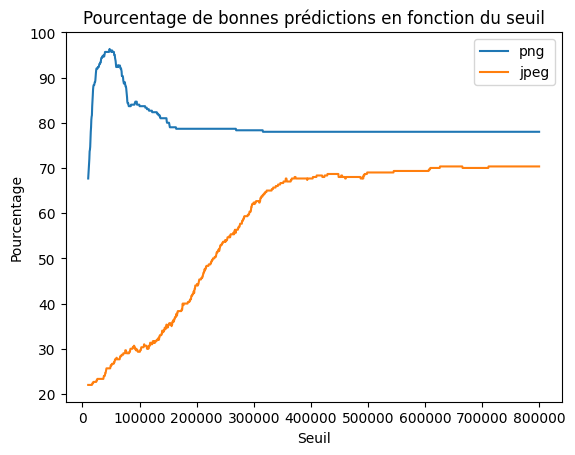

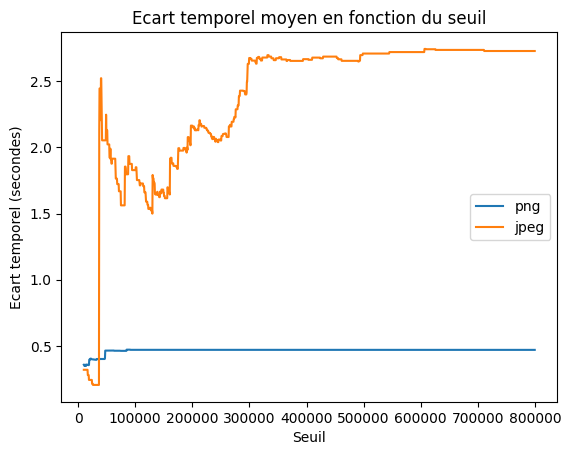

In [23]:
#Traitement images jpeg et png en faisant varier le seuil avec une mémorisation des distances pour ne pas avoir à les recalculer
Distances= {"png" : {}, "jpeg" : {}}

for ext in ["png","jpeg"]:
    for image in tqdm(os.listdir(f"./data/test/{ext}/")):
        Resultat = rechercheImage(f"./data/test/{ext}/{image}",dictVideo)
        # clear_output(wait=True)
        video = Resultat[0]
        minutage = Resultat[1]
        distance = Resultat[2]
        Distances[ext][image] = [distance, video, minutage]


Seuils = {"png" : [], "jpeg" : []}
Pourcentages = {"png" : [], "jpeg" : []}
EcartTemp = {"png" : [], "jpeg" : []}
for ext in ["png","jpeg"]:
        for seuil in range(10000, 800000, 500):
            Resultats = {"png" : [], "jpeg" : []}
            Resultats[ext].append(['image', 'video_pred', 'minutage_pred'])
            for image in tqdm(os.listdir(f"./data/test/{ext}/")):
                distance, video, minutage = Distances[ext][image]
                if distance > seuil: # cas ou on ne détecte pas l'image dans une vidéo
                    if ext == "jpeg":
                        Resultats[ext].append([image[0:-5], "out", None])
                    else:
                        Resultats[ext].append([image[0:-4], "out", None])
                else:
                    if ext == "jpeg":
                        Resultats[ext].append([image[0:-5], video[0:-4], minutage])
                    else:
                        Resultats[ext].append([image[0:-4], video[0:-4], minutage])

            with open(f'results/test_gt_{ext}_Q3.csv', 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerows(Resultats[ext])

            file_gt = "data/test/test_gt.csv"
            file = f"results/test_gt_{ext}_Q3.csv"
            pourcentage, b, c = evaluate(file,file_gt)
            clear_output(wait=True)
            Seuils[ext].append(seuil)
            Pourcentages[ext].append(pourcentage)
            EcartTemp[ext].append(b)
            print("\n")


# ----------------- Affichage des résultats -----------------
plt.plot(Seuils["png"], Pourcentages["png"], label="png")
plt.plot(Seuils["jpeg"], Pourcentages["jpeg"], label="jpeg")
plt.legend()
plt.xlabel("Seuil")
plt.ylabel("Pourcentage")
plt.title("Pourcentage de bonnes prédictions en fonction du seuil")
plt.show()

plt.plot(Seuils["png"], EcartTemp["png"], label="png")
plt.plot(Seuils["jpeg"], EcartTemp["jpeg"], label="jpeg")
plt.legend()
plt.xlabel("Seuil")
plt.ylabel("Ecart temporel (secondes)")
plt.title("Ecart temporel moyen en fonction du seuil")
plt.show()

#### Utilisation des meilleurs valeurs du seuil en fonction du type d'image

In [24]:
#Traitement images png pour la meilleure valeur de seuil
Resultat_png = []
Resultat_png.append(['image', 'video_pred', 'minutage_pred'])

for image in tqdm(os.listdir("./data/test/png/")):
    video, minutage = rechercheImageSeuil(f"./data/test/png/{image}",dictVideo, 50000)
    if video == "None":
        Resultat_png.append([image[0:-4], "out", None])
    else:
        Resultat_png.append([image[0:-4], video[0:-4], minutage])

with open('results/test_gt_png_Q3.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(Resultat_png)

print("Résultats png")
file_gt = "data/test/test_gt.csv"
file ="results/test_gt_png_Q3.csv"
evaluate(file,file_gt)

#Traitement images jpeg pour la meilleure valeur de seuil
Resultat_jpeg = [] 
Resultat_jpeg.append(['image', 'video_pred', 'minutage_pred'])

for image in tqdm(os.listdir("./data/test/jpeg/")):
    video = rechercheImageSeuil(f"./data/test/jpeg/{image}",dictVideo, 800000)[0]
    minutage = rechercheImageSeuil(f"./data/test/jpeg/{image}",dictVideo, 800000)[1]
    if video == "None":
        Resultat_jpeg.append([image[0:-5], "out", None])
    else:
        Resultat_jpeg.append([image[0:-5], video[0:-4], minutage])

with open('results/test_gt_jpeg_Q3.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(Resultat_jpeg)

print("\n")
print("Résultats jpeg")
file_gt = "data/test/test_gt.csv"
file ="results/test_gt_jpeg_Q3.csv"
evaluate(file,file_gt)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:06<00:00, 48.99it/s]


Résultats png
Taux de bonnes réponses : 96.0% (288/300)
Ecart temporel moyen : 0.46 sec


100%|██████████| 300/300 [00:08<00:00, 37.32it/s]



Résultats jpeg
Taux de bonnes réponses : 70.3% (211/300)
Ecart temporel moyen : 2.73 sec


(70.33333333333333, 2.7276642969984204, 211)

## HOG

#### Traitement des vidéos

In [25]:
PATH = "./data/mp4/"
fichiers = os.listdir(PATH)
dictVideo = {}

# Revoir arguments
hog = cv2.HOGDescriptor(_winSize = (32,32), _blockSize = (32, 32), _blockStride = (1,1), _cellSize = (16, 16),_nbins = 8 )

# Lecture des frames
for k in tqdm(range(len(fichiers))):
    print(fichiers[k])
    cam = cv2.VideoCapture('./data/mp4/'+fichiers[k])
    dictVideo[fichiers[k]] = []
    fps = cam.get(cv2.CAP_PROP_FPS)
    numeroImage = 0
    ret, frame = cam.read()
    while ret:
        if numeroImage % round(fps)==0:
            hogDescriptor = hog.compute(frame)
            dictVideo[fichiers[k]].append(hogDescriptor)
        numeroImage += 1
        ret, frame = cam.read()
    cam.release
    clear_output(wait=True)

100%|██████████| 100/100 [01:05<00:00,  1.54it/s]


#### Traitement des images

In [26]:
def rechercheImageHOG(image,dictVideo, seuil = None):
    """
    Recherche d'une image dans le dictionnaire d'images des vidéos (HOG)

    Args
    ----
    image : image à rechercher
    dictVideo : dictionnaire des images conservées des vidéos (HOG)
    seuil : seuil pour détecter les images dans aucune vidéos, si None alors pas de seuil
    
    Returns
    -------
    min_vid_corresp : numéro de la vidéo correspondante
    min_im_corresp : numéro de l'image correspondante

    """
    img = cv2.imread(image)
    hog = cv2.HOGDescriptor(_winSize = (32,32), _blockSize = (32, 32), _blockStride = (1,1), _cellSize = (16, 16),_nbins = 8 )
    HOGImRecherchee = hog.compute(img)
    min_vid_corresp = None
    min_im_corresp = None
    minDist = np.inf
    for key in dictVideo.keys():
        for i,histo in enumerate(dictVideo[key]):
            if np.linalg.norm(HOGImRecherchee - histo) < minDist:
                min_vid_corresp = key
                min_im_corresp = i
                minDist = np.linalg.norm(HOGImRecherchee - histo)
    if (seuil != None) and (minDist > seuil): # cas ou on ne détecte pas l'image dans une vidéo
        min_vid_corresp = "None"
        min_im_corresp = "None"
    return min_vid_corresp, min_im_corresp, minDist

##### Pas d'utilisation de seuils ici

In [27]:
for ext in ["png","jpeg"]:
    Resultats = []
    Resultats.append(['image', 'video_pred', 'minutage_pred'])
    for image in tqdm(os.listdir(f"./data/test/{ext}/")):
        resultat = rechercheImageHOG(f"./data/test/{ext}/{image}",dictVideo)
        video = resultat[0]
        minutage = resultat[1]
        if video == "None":
            if ext == "jpeg":
                Resultats.append([image[0:-5], "out", None])
            else:
                Resultats.append([image[0:-4], "out", None])
        else:
            if ext == "jpeg":
                Resultats.append([image[0:-5], video[0:-4], minutage])
            else:
                Resultats.append([image[0:-4], video[0:-4], minutage])
        clear_output(wait=True)


    with open(f'results/test_gt_{ext}_Q3.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(Resultats)


print("Résultats png sans seuil")
file_gt = "data/test/test_gt.csv"
file ="results/test_gt_png_Q3.csv"
evaluate(file,file_gt)

print("Résultats jpeg sans seuil")
file_gt = "data/test/test_gt.csv"
file ="results/test_gt_jpeg_Q3.csv"
evaluate(file,file_gt)

100%|██████████| 300/300 [00:19<00:00, 15.27it/s]

Résultats png sans seuil
Taux de bonnes réponses : 76.0% (228/300)
Ecart temporel moyen : 0.31 sec
Résultats jpeg sans seuil
Taux de bonnes réponses : 64.0% (192/300)
Ecart temporel moyen : 0.52 sec


(64.0, 0.5165532118055555, 192)

##### Tuning du paramètre de seuil

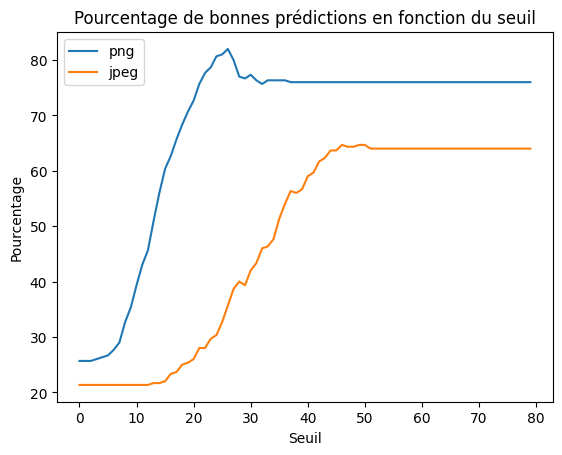

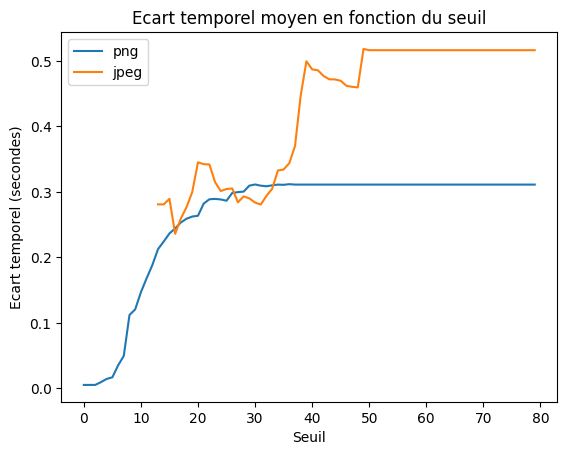

In [28]:
#Traitement des images tests en faisant varier le seuil avec une mémorisation des distances pour ne pas avoir à les recalculer
Distances= {"png" : {}, "jpeg" : {}}

for ext in ["png","jpeg"]:
    for image in tqdm(os.listdir(f"./data/test/{ext}/")):
        Resultat = rechercheImageHOG(f"./data/test/{ext}/{image}",dictVideo)
        # clear_output(wait=True)
        video = Resultat[0]
        minutage = Resultat[1]
        distance = Resultat[2]
        Distances[ext][image] = [distance, video, minutage]

Seuils = {"png" : [], "jpeg" : []}
Pourcentages = {"png" : [], "jpeg" : []}
EcartTemp = {"png" : [], "jpeg" : []}
for ext in ["png","jpeg"]:
    for seuil in range(0,80,1):
        Resultats = {"png" : [], "jpeg" : []}
        Resultats[ext].append(['image', 'video_pred', 'minutage_pred'])
        for image in tqdm(os.listdir(f"./data/test/{ext}/")):
            distance, video, minutage = Distances[ext][image]
            if distance > seuil: # cas ou on ne détecte pas l'image dans une vidéo
                if ext == "jpeg":
                    Resultats[ext].append([image[0:-5], "out", None])
                else:
                    Resultats[ext].append([image[0:-4], "out", None])
            else:
                if ext == "jpeg":
                    Resultats[ext].append([image[0:-5], video[0:-4], minutage])
                else:
                    Resultats[ext].append([image[0:-4], video[0:-4], minutage])

        with open(f'results/test_gt_{ext}_Q3.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(Resultats[ext])

        file_gt = "data/test/test_gt.csv"
        file = f"results/test_gt_{ext}_Q3.csv"
        pourcentage, a,b = evaluate(file,file_gt)
        if a == None:
            evaluate(file,file_gt)
        clear_output(wait=True)
        Seuils[ext].append(seuil)
        EcartTemp[ext].append(a)
        Pourcentages[ext].append(pourcentage)
        print("\n")



# ----------------- Affichage des résultats -----------------
plt.plot(Seuils["png"], Pourcentages["png"], label="png")
plt.plot(Seuils["jpeg"], Pourcentages["jpeg"], label="jpeg")
plt.legend()
plt.xlabel("Seuil")
plt.ylabel("Pourcentage")
plt.title("Pourcentage de bonnes prédictions en fonction du seuil")
plt.show()

plt.plot(Seuils["png"], EcartTemp["png"], label="png")
plt.plot(Seuils["jpeg"], EcartTemp["jpeg"], label="jpeg")
plt.legend()
plt.xlabel("Seuil")
plt.ylabel("Ecart temporel (secondes)")
plt.title("Ecart temporel moyen en fonction du seuil")
plt.show()

## ResNet50

In [11]:
def histoImageResNet(image, model):
    """
    image : image à traiter
    model : modèle ResNet50 pré-entrainé utilisé
    """
    image_resize = cv2.resize(image, (224, 224))
    image_resize = np.expand_dims(image_resize, axis=0)
    hist = model.predict(image_resize).flatten()
    
    return hist

def rechercheImageResNet(image,dictVideo, seuil = None):
    """
    Recherche d'une image dans le dictionnaire d'images des vidéos

    Args
    ----
    image : image à rechercher
    dictVideo : dictionnaire des images conservées des vidéos
    seuil : seuil pour détecter les images dans aucune vidéos, si None alors pas de seuil
    
    Returns
    -------
    min_vid_corresp : numéro de la vidéo correspondante
    min_im_corresp : numéro de l'image correspondante

    """
    img = load_img(image, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    pred = model.predict(img)
    min_vid_corresp = None
    min_im_corresp = None
    minDist = np.inf
    for key in dictVideo.keys():
        for i,histo in enumerate(dictVideo[key]):
            if np.linalg.norm(pred - histo) < minDist:
                min_vid_corresp = key
                min_im_corresp = i
                minDist = np.linalg.norm(pred - histo)
    if (seuil != None) and (minDist > seuil): # cas ou on ne détecte pas l'image dans une vidéo
        min_vid_corresp = "None"
        min_im_corresp = "None"
    return min_vid_corresp, min_im_corresp, minDist

> Tests sans les seuils

In [ ]:
# ----------------- Création du dictionnaire de vidéos -----------------
fichiers = os.listdir("./data/mp4/")
dictVideoTest = {}

model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Lecture des frames
for k in tqdm(range(len(fichiers))):
    cam = cv2.VideoCapture('./data/mp4/'+fichiers[k])
    dictVideoTest[fichiers[k]] = []
    fps = cam.get(cv2.CAP_PROP_FPS)
    numeroImage = 0
    ret, frame = cam.read()
    while ret:
        if numeroImage % round(fps)==0:
            histoConcatene = histoImageResNet(frame)
            dictVideoTest[fichiers[k]].append(histoConcatene)
        numeroImage += 1
        ret, frame = cam.read()
    cam.release
    clear_output(wait=True)

In [33]:
# ----------------- Traitements des images tests -----------------
for ext in ["png","jpeg"]:
    Resultats = []
    Resultats.append(['image', 'video_pred', 'minutage_pred'])
    for image in tqdm(os.listdir(f"./data/test/{ext}/")):
        resultat = rechercheImageResNet(f"./data/test/{ext}/{image}",dictVideoTest)
        video = resultat[0]
        minutage = resultat[1]
        if video == "None":
            if ext == "jpeg":
                Resultats.append([image[0:-5], "out", None])
            else:
                Resultats.append([image[0:-4], "out", None])
        else:
            if ext == "jpeg":
                Resultats.append([image[0:-5], video[0:-4], minutage])
            else:
                Resultats.append([image[0:-4], video[0:-4], minutage])
        clear_output(wait=True)


    with open(f'results/test_gt_{ext}_Q3.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(Resultats)


print("Résultats png sans seuil")
file_gt = "data/test/test_gt.csv"
file ="results/test_gt_png_Q3.csv"
evaluate(file,file_gt)

print("Résultats jpeg sans seuil")
file_gt = "data/test/test_gt.csv"
file ="results/test_gt_jpeg_Q3.csv"
evaluate(file,file_gt)


100%|██████████| 300/300 [00:36<00:00,  8.21it/s]

Résultats png sans seuil
Taux de bonnes réponses : 78.0% (234/300)
Ecart temporel moyen : 2.46 sec
Résultats jpeg sans seuil
Taux de bonnes réponses : 77.3% (232/300)
Ecart temporel moyen : 2.91 sec


(77.33333333333333, 2.9118035201149426, 232)

##### Tuning du paramètre seuil

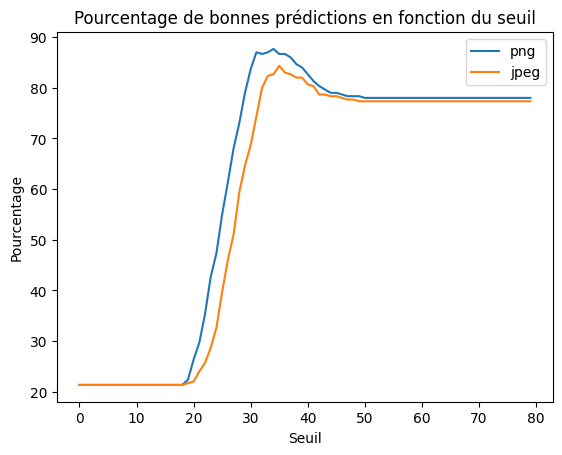

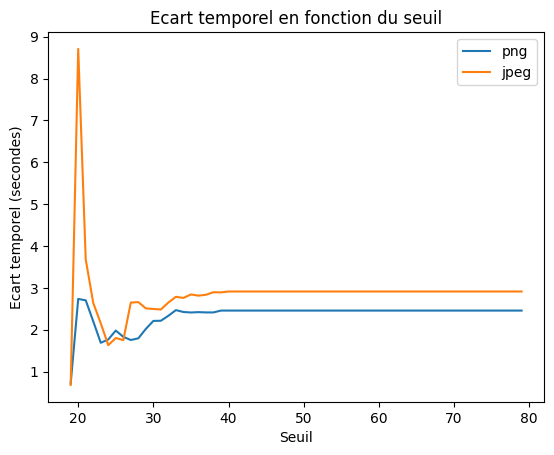

In [34]:
#Traitement images jpeg et png  avec une mémorisation des distances pour ne pas avoir à les recalculer

Distances= {"png" : {}, "jpeg" : {}}

for ext in ["png","jpeg"]:
    for image in tqdm(os.listdir(f"./data/test/{ext}/")):
        Resultat = rechercheImageResNet(f"./data/test/{ext}/{image}",dictVideoTest)
        # clear_output(wait=True)
        video = Resultat[0]
        minutage = Resultat[1]
        distance = Resultat[2]
        Distances[ext][image] = [distance, video, minutage]
        clear_output(wait=True)
        
Seuils = {"png" : [], "jpeg" : []}
Pourcentages = {"png" : [], "jpeg" : []}
EcartTemp = {"png" : [], "jpeg" : []}

for ext in ["png","jpeg"]:
    for seuil in range(0,80,1):
        Resultats = {"png" : [], "jpeg" : []}
        Resultats[ext].append(['image', 'video_pred', 'minutage_pred'])
        for image in tqdm(os.listdir(f"./data/test/{ext}/")):
            distance, video, minutage = Distances[ext][image]
            if distance > seuil: # cas ou on ne détecte pas l'image dans une vidéo
                if ext == "jpeg":
                    Resultats[ext].append([image[0:-5], "out", None])
                else:
                    Resultats[ext].append([image[0:-4], "out", None])
            else:
                if ext == "jpeg":
                    Resultats[ext].append([image[0:-5], video[0:-4], minutage])
                else:
                    Resultats[ext].append([image[0:-4], video[0:-4], minutage])

        with open(f'results/test_gt_{ext}_Q3.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(Resultats[ext])

        file_gt = "data/test/test_gt.csv"
        file = f"results/test_gt_{ext}_Q3.csv"
        pourcentage,a,b = evaluate(file,file_gt)
        clear_output(wait=True)
        Seuils[ext].append(seuil)
        Pourcentages[ext].append(pourcentage)
        EcartTemp[ext].append(a)
        print("\n")

plt.plot(Seuils["png"], Pourcentages["png"], label="png")
plt.plot(Seuils["jpeg"], Pourcentages["jpeg"], label="jpeg")
plt.legend()
plt.xlabel("Seuil")
plt.ylabel("Pourcentage")
plt.title("Pourcentage de bonnes prédictions en fonction du seuil")
plt.show()

plt.plot(Seuils["png"], EcartTemp["png"], label="png")
plt.plot(Seuils["jpeg"], EcartTemp["jpeg"], label="jpeg")
plt.legend()
plt.xlabel("Seuil")
plt.ylabel("Ecart temporel (secondes)")
plt.title("Ecart temporel en fonction du seuil")
plt.show()

## Algorithme final : Mix des méthodes (ResNet + HOG)

In [18]:
def rechercheImageMix(image,dictVideo, model, seuil = None):
    """
    Recherche d'une image dans le dictionnaire d'images des vidéos : ResNet50 (pour le numéro de la vidéo) + HOG (pour le numéro de l'image)

    Args
    ----
    image : image à rechercher
    dictVideo : dictionnaire des images conservées des vidéos
    model : modèle ResNet50 pré-entrainé utilisé
    seuil : seuil pour détecter les images dans aucune vidéos, si None alors pas de seuil
    
    Returns
    -------
    min_vid_corresp : numéro de la vidéo correspondante
    min_im_corresp : numéro de l'image correspondante

    """
    img = load_img(image, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    pred = model.predict(img)

    img = cv2.imread(image)
    hog = cv2.HOGDescriptor(_winSize = (32,32), _blockSize = (32, 32), _blockStride = (1,1), _cellSize = (16, 16),_nbins = 8 )
    HOGImRecherchee = hog.compute(img)
    
    min_vid_corresp = None
    minDist = np.inf

    # Détection de la vidéo
    for key in dictVideo.keys():
        for i,histo in enumerate(dictVideo[key]["ResNet"]):
            if np.linalg.norm(pred - histo) < minDist:
                min_vid_corresp = key
                minDist = np.linalg.norm(pred - histo)
    if (seuil != None) and (minDist > seuil): # cas ou on ne détecte pas l'image dans une vidéo
        min_vid_corresp = "None"
        min_im_corresp = "None"
    # Détection du moment de la vidéo
    else :
        min_im_corresp = None
        distMin = np.inf
        for i,histo in enumerate(dictVideo[min_vid_corresp]["HOG"]):
            if np.linalg.norm(HOGImRecherchee - histo) < distMin:
                min_im_corresp = i
                distMin = np.linalg.norm(HOGImRecherchee - histo)
                
    return min_vid_corresp, min_im_corresp, minDist

##### Création du dictionnaire des vidéos

In [36]:
PATH = "./data/mp4/"
fichiers = os.listdir(PATH)
dictVideo = {}

hog = cv2.HOGDescriptor(_winSize = (32,32), _blockSize = (32, 32), _blockStride = (1,1), _cellSize = (16, 16),_nbins = 8 )

# Lecture des frames
for k in tqdm(range(len(fichiers))):
    print(fichiers[k])
    cam = cv2.VideoCapture('./data/mp4/'+fichiers[k])
    dictVideo[fichiers[k]] = []
    fps = cam.get(cv2.CAP_PROP_FPS)
    numeroImage = 0
    ret, frame = cam.read()
    dictVideo[fichiers[k]] = {"HOG" :[], "ResNet" : []}
    while ret:
        if numeroImage % round(fps)==0:
            hogDescriptor = hog.compute(frame)
            histoResNet = histoImageResNet(frame)
            dictVideo[fichiers[k]]["HOG"].append(hogDescriptor)
            dictVideo[fichiers[k]]["ResNet"].append(histoResNet)
        numeroImage += 1
        ret, frame = cam.read()
    cam.release
    clear_output(wait=True)

100%|██████████| 100/100 [03:25<00:00,  2.05s/it]


##### Tuning du paramètre seuil (et comparaison entre les taux de bonnes prédictions et l'écart temporel moyen)

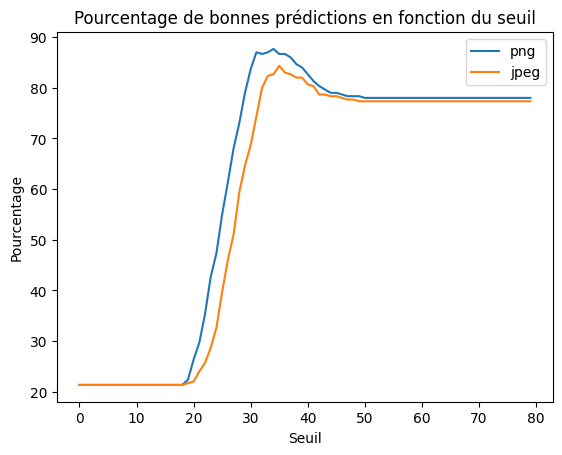

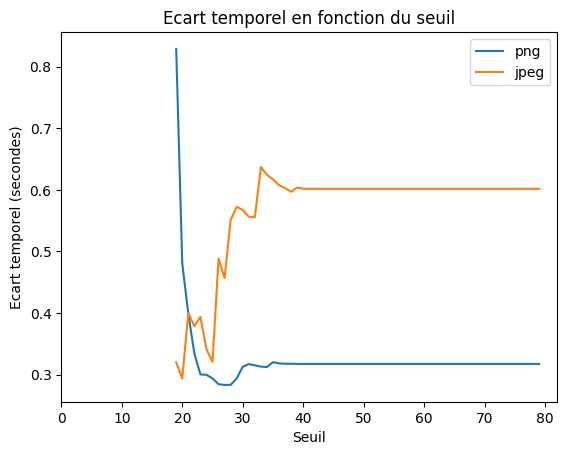

In [37]:
#Traitement images jpeg et png  avec une mémorisation des distances pour ne pas avoir à les recalculer

Distances= {"png" : {}, "jpeg" : {}}

for ext in ["png","jpeg"]:
    for image in tqdm(os.listdir(f"./data/test/{ext}/")):
        Resultat = rechercheImageMix(f"./data/test/{ext}/{image}",dictVideo)
        # clear_output(wait=True)
        video = Resultat[0]
        minutage = Resultat[1]
        distance = Resultat[2]
        Distances[ext][image] = [distance, video, minutage]
        clear_output(wait=True)
        
Seuils = {"png" : [], "jpeg" : []}
Pourcentages = {"png" : [], "jpeg" : []}
EcartTemp = {"png" : [], "jpeg" : []}

for ext in ["png","jpeg"]:
    for seuil in range(0,80,1):
        Resultats = {"png" : [], "jpeg" : []}
        Resultats[ext].append(['image', 'video_pred', 'minutage_pred'])
        for image in tqdm(os.listdir(f"./data/test/{ext}/")):
            distance, video, minutage = Distances[ext][image]
            if distance > seuil: # cas ou on ne détecte pas l'image dans une vidéo
                if ext == "jpeg": # distinction entre les extensions jpeg et png seulement pour enlever l'extension
                    Resultats[ext].append([image[0:-5], "out", None])
                else:
                    Resultats[ext].append([image[0:-4], "out", None])
            else:
                if ext == "jpeg":
                    Resultats[ext].append([image[0:-5], video[0:-4], minutage])
                else:
                    Resultats[ext].append([image[0:-4], video[0:-4], minutage])

        with open(f'results/test_gt_{ext}_Q3.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(Resultats[ext])

        file_gt = "data/test/test_gt.csv"
        file = f"results/test_gt_{ext}_Q3.csv"
        pourcentage,a,b = evaluate(file,file_gt)
        clear_output(wait=True)
        Seuils[ext].append(seuil)
        Pourcentages[ext].append(pourcentage)
        EcartTemp[ext].append(a)
        print("\n")

plt.plot(Seuils["png"], Pourcentages["png"], label="png")
plt.plot(Seuils["jpeg"], Pourcentages["jpeg"], label="jpeg")
plt.legend()
plt.xlabel("Seuil")
plt.ylabel("Pourcentage")
plt.title("Pourcentage de bonnes prédictions en fonction du seuil")
plt.show()

plt.plot(Seuils["png"], EcartTemp["png"], label="png")
plt.plot(Seuils["jpeg"], EcartTemp["jpeg"], label="jpeg")
plt.xlim(0)
plt.legend()
plt.xlabel("Seuil")
plt.ylabel("Ecart temporel (secondes)")
plt.title("Ecart temporel en fonction du seuil")
plt.show()

## Création de notre fonction de recherche complète

In [20]:
def creationDictVideo(PATHVideo, model):
    """
    Création d'un dictionnaire des vidéos avec les images gardées

    Args
    ----
    PATHVideo : chemin vers les vidéos
    model : modèle ResNet50 pré-entrainé utilisé
    
    Returns
    -------
    dictVideo : dictionnaire des vidéos avec les images gardées

    """

    fichiers = os.listdir(PATHVideo)
    dictVideo = {}

    hog = cv2.HOGDescriptor(_winSize = (32,32), _blockSize = (32, 32), _blockStride = (1,1), _cellSize = (16, 16),_nbins = 8 )

    # Lecture des frames
    for k in tqdm(range(len(fichiers))):
        print(fichiers[k])
        cam = cv2.VideoCapture(PATHVideo+fichiers[k])
        dictVideo[fichiers[k]] = []
        fps = cam.get(cv2.CAP_PROP_FPS)
        numeroImage = 0
        ret, frame = cam.read()
        dictVideo[fichiers[k]] = {"HOG" :[], "ResNet" : []}
        while ret:
            if numeroImage % round(fps)==0:
                hogDescriptor = hog.compute(frame)
                histoResNet = histoImageResNet(frame,model)
                dictVideo[fichiers[k]]["HOG"].append(hogDescriptor)
                dictVideo[fichiers[k]]["ResNet"].append(histoResNet)
            numeroImage += 1
            ret, frame = cam.read()
        cam.release
        clear_output(wait=True)

    return dictVideo

def pipelineCompleteRecherche(PATHVideo, PATHImageListe, PATHResultats, nomFichierListe, seuil = 35):
    """
    Recherche d'une image dans le dictionnaire d'images des vidéos

    Args
    ----
    PATHVideo : chemin vers les vidéos
    PATHImage : chemin vers les images à rechercher
    PATHResultats : chemin vers le fichier de résultats
    NomFichier : nom du fichier de résultats
    seuil : seuil pour détecter les images dans aucune vidéos, si None alors pas de seuil
    
    Returns
    -------
    temps_import_model : temps d'import du modèle
    temps_traitement_video : temps de traitement des vidéos
    temps_traitement_image : temps de traitement des images

    """
    temps_debut = time.time()

    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    fin_import_model = time.time()

    Distances= {}

    dictVideo = creationDictVideo(PATHVideo,model)
    fin_traitement_video = time.time()

    for i,PATHImage in enumerate(PATHImageListe):
        for image in tqdm(os.listdir(PATHImage)):
            Resultat = rechercheImageMix(PATHImage + image, dictVideo, model, seuil = seuil)
            video = Resultat[0]
            minutage = Resultat[1]
            distance = Resultat[2]
            Distances[image] = [distance, video, minutage]
            clear_output(wait=True)
        clear_output(wait=True)

        nom_image = os.listdir(PATHImage)[0]
        elements = nom_image.split(".")
        ext = elements[-1]

        Resultats = []
        Resultats.append(['image', 'video_pred', 'minutage_pred'])
        for image in tqdm(os.listdir(PATHImage)):
            distance, video, minutage = Distances[image]
            if distance > seuil: # cas ou on ne détecte pas l'image dans une vidéo
                if ext == "jpeg":
                    Resultats.append([image[0:-5], "out", None])
                else:
                    Resultats.append([image[0:-4], "out", None])
            else:
                if ext == "jpeg":
                    Resultats.append([image[0:-5], video[0:-4], minutage])
                else:
                    Resultats.append([image[0:-4], video[0:-4], minutage])

        with open(PATHResultats + nomFichierListe[i], 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(Resultats)

    fin_traitement_image = time.time()

    temps_import_model = fin_import_model - temps_debut
    temps_traitement_video = fin_traitement_video - fin_import_model
    temps_traitement_image = fin_traitement_image - fin_traitement_video

    return temps_import_model, temps_traitement_video, temps_traitement_image

In [21]:
temps_import_model, temps_traitement_video, temps_traitement_image = pipelineCompleteRecherche("./data/mp4/", ["./data/test/png/","./data/test/jpeg/"], "./results/", ["test_gt_png_Q3.csv","test_gt_jpeg_Q3.csv"])

file_gt = "data/test/test_gt.csv"
file = "results/test_gt_png_Q3.csv"
print("Résultats pour les PNG")
evaluate(file,file_gt)
print("\n")

print("Résultats pour les JPEG")
file_gt = "data/test/test_gt.csv"
file = "results/test_gt_jpeg_Q3.csv"
evaluate(file,file_gt)

print(f"Temps d'import du modèle : {round(temps_import_model,2)} secondes")
print(f"Temps de traitement des vidéos : {round(temps_traitement_video,2)} secondes")
print(f"Temps de traitement des images : {round(temps_traitement_image,2)} secondes")
print(f"Temps total de traitement : {round(temps_import_model + temps_traitement_video + temps_traitement_image,2)} secondes")

100%|██████████| 300/300 [00:00<?, ?it/s]

Taux de bonnes réponses : 86.7% (260/300)
Ecart temporel moyen : 0.32 sec
Taux de bonnes réponses : 84.3% (253/300)
Ecart temporel moyen : 0.62 sec
Temps d'import du modèle : 1.6365642547607422 secondes
Temps de traitement des vidéos : 393.59109377861023 secondes
Temps de traitement des images : 154.57364082336426 secondes
Temps total de traitement : 549.8012988567352 secondes


# Q4 - Challenge

In [22]:
temps_import_model, temps_traitement_video, temps_traitement_image = pipelineCompleteRecherche("./data/mp4/", ["./data/challenge/png/","./data/challenge/jpeg/"], "./results/", [" challenge_png.csv","challenge_jpeg.csv"])

print(f"Temps d'import du modèle : {round(temps_import_model,2)} secondes")
print(f"Temps de traitement des vidéos : {round(temps_traitement_video,2)} secondes")
print(f"Temps de traitement des images : {round(temps_traitement_image,2)} secondes")
print(f"Temps total de traitement : {round(temps_import_model + temps_traitement_video + temps_traitement_image,2)} secondes")

100%|██████████| 300/300 [00:00<?, ?it/s]

Temps d'import du modèle : 1.591721773147583 secondes
Temps de traitement des vidéos : 416.8821270465851 secondes
Temps de traitement des images : 154.62642574310303 secondes
Temps total de traitement : 573.1002745628357 secondes
